In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import mdn

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 11025
overlap = 5512

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 6.045388698577881
(14019, 1, 11025)


In [12]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [13]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 44, 1)        296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 5s 2s/step - loss: 1479.3451
(1, 11025)


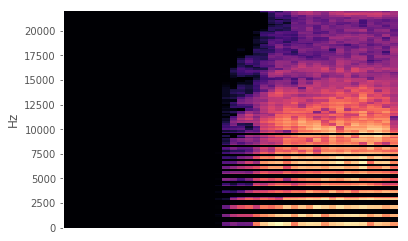

(14019, 128, 44)


In [16]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

src = np.random.random((1, blocksize))
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False,
    fmin = 800,
    fmax = 8000
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)
n_targets = np.repeat(targets, mfccs.shape[1])
cat_targets = np.repeat(c_targets, mfccs.shape[1])

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 100
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, 11025),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [18]:
frames = mfccs

In [19]:
frames = np.expand_dims(frames, axis=3)
frames.shape

(14019, 128, 44, 1)

In [20]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_2 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 36, 32)       2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

9532/9532 [==============================] - 7s 786us/step - loss: 0.3999 - acc: 0.8065 - mean_absolute_error: 0.2769 - val_loss: 0.4674 - val_acc: 0.7706 - val_mean_absolute_error: 0.3070
Epoch 36/100
9532/9532 [==============================] - 7s 725us/step - loss: 0.3942 - acc: 0.8117 - mean_absolute_error: 0.2723 - val_loss: 0.4676 - val_acc: 0.7772 - val_mean_absolute_error: 0.3080
Epoch 37/100
9532/9532 [==============================] - 5s 555us/step - loss: 0.4037 - acc: 0.8043 - mean_absolute_error: 0.2780 - val_loss: 0.4626 - val_acc: 0.7677 - val_mean_absolute_error: 0.3037
Epoch 38/100
9532/9532 [==============================] - 6s 611us/step - loss: 0.3964 - acc: 0.8116 - mean_absolute_error: 0.2728 - val_loss: 0.5020 - val_acc: 0.7493 - val_mean_absolute_error: 0.2999
Epoch 39/100
9532/9532 [==============================] - 8s 842us/step - loss: 0.3920 - acc: 0.8126 - mean_absolute_error: 0.2701 - val_loss: 0.4600 - val_acc: 0.7790 - val_mean_absolute_error: 0.3027
Epo

Epoch 76/100
9532/9532 [==============================] - 9s 918us/step - loss: 0.3226 - acc: 0.8482 - mean_absolute_error: 0.2202 - val_loss: 0.4670 - val_acc: 0.7920 - val_mean_absolute_error: 0.2650
Epoch 77/100
9532/9532 [==============================] - 9s 893us/step - loss: 0.3157 - acc: 0.8523 - mean_absolute_error: 0.2163 - val_loss: 0.4684 - val_acc: 0.7962 - val_mean_absolute_error: 0.2753
Epoch 78/100
9532/9532 [==============================] - 8s 814us/step - loss: 0.3212 - acc: 0.8471 - mean_absolute_error: 0.2185 - val_loss: 0.4527 - val_acc: 0.7962 - val_mean_absolute_error: 0.2641
Epoch 79/100
9532/9532 [==============================] - 9s 960us/step - loss: 0.3195 - acc: 0.8489 - mean_absolute_error: 0.2167 - val_loss: 0.4723 - val_acc: 0.7772 - val_mean_absolute_error: 0.2603
Epoch 80/100
9532/9532 [==============================] - 9s 948us/step - loss: 0.3128 - acc: 0.8497 - mean_absolute_error: 0.2138 - val_loss: 0.4723 - val_acc: 0.7819 - val_mean_absolute_erro

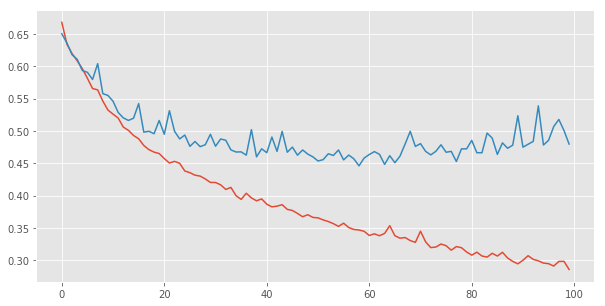

In [21]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

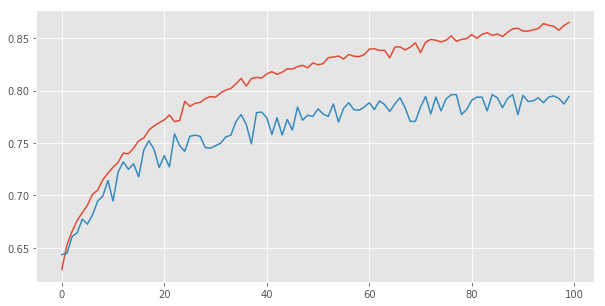

In [22]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.8084878744650499
Confusion matrix, without normalization
[[ 665  378]
 [ 159 1602]]


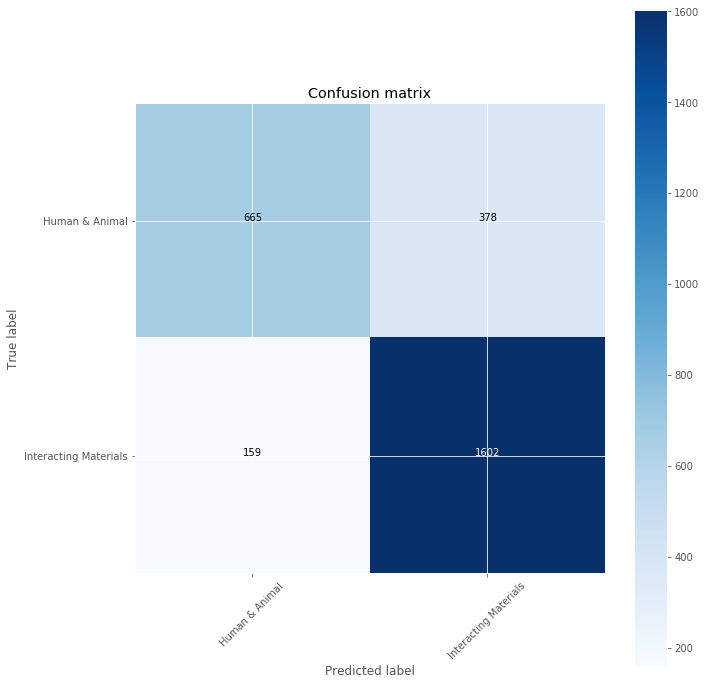

In [23]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# Deep Net
Separate into classes

# Animal Sounds

In [24]:
train_X, test_X, train_y, test_y = train_test_split(
                        a_data, a_targ, test_size=0.20, random_state=56)

In [25]:
def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, (3, 3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [26]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=epochs * 2, 
                       batch_size=batch, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_3 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 42, 32)       320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 2, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               41088     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

Epoch 31/200
3515/3515 [==============================] - 3s 777us/step - loss: 1.8265 - acc: 0.3989 - mean_absolute_error: 0.0761 - val_loss: 1.7263 - val_acc: 0.4332 - val_mean_absolute_error: 0.0728
Epoch 32/200
3515/3515 [==============================] - 3s 754us/step - loss: 1.8235 - acc: 0.4102 - mean_absolute_error: 0.0760 - val_loss: 1.7797 - val_acc: 0.4348 - val_mean_absolute_error: 0.0753
Epoch 33/200
3515/3515 [==============================] - 3s 863us/step - loss: 1.8479 - acc: 0.4114 - mean_absolute_error: 0.0766 - val_loss: 1.7158 - val_acc: 0.4187 - val_mean_absolute_error: 0.0737
Epoch 34/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.7947 - acc: 0.4199 - mean_absolute_error: 0.0746 - val_loss: 1.7455 - val_acc: 0.4412 - val_mean_absolute_error: 0.0749
Epoch 35/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.7582 - acc: 0.4262 - mean_absolute_error: 0.0744 - val_loss: 1.7005 - val_acc: 0.4380 - val_mean_absolute_error: 0

Epoch 72/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.4740 - acc: 0.5297 - mean_absolute_error: 0.0633 - val_loss: 1.4634 - val_acc: 0.5556 - val_mean_absolute_error: 0.0639
Epoch 73/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.4342 - acc: 0.5457 - mean_absolute_error: 0.0626 - val_loss: 1.4545 - val_acc: 0.5443 - val_mean_absolute_error: 0.0615
Epoch 74/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.3612 - acc: 0.5516 - mean_absolute_error: 0.0609 - val_loss: 1.4154 - val_acc: 0.5652 - val_mean_absolute_error: 0.0602
Epoch 75/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.3614 - acc: 0.5605 - mean_absolute_error: 0.0598 - val_loss: 1.4383 - val_acc: 0.5539 - val_mean_absolute_error: 0.0593
Epoch 76/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.3912 - acc: 0.5514 - mean_absolute_error: 0.0606 - val_loss: 1.4066 - val_acc: 0.5588 - val_mean_absolute_error: 0.0599


Epoch 113/200
3515/3515 [==============================] - 3s 947us/step - loss: 1.1851 - acc: 0.6179 - mean_absolute_error: 0.0536 - val_loss: 1.2975 - val_acc: 0.5958 - val_mean_absolute_error: 0.0545
Epoch 114/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.1800 - acc: 0.6196 - mean_absolute_error: 0.0522 - val_loss: 1.3174 - val_acc: 0.5829 - val_mean_absolute_error: 0.0551
Epoch 115/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.2393 - acc: 0.6020 - mean_absolute_error: 0.0551 - val_loss: 1.3141 - val_acc: 0.6006 - val_mean_absolute_error: 0.0531
Epoch 116/200
3515/3515 [==============================] - 3s 895us/step - loss: 1.2206 - acc: 0.6100 - mean_absolute_error: 0.0547 - val_loss: 1.3376 - val_acc: 0.5878 - val_mean_absolute_error: 0.0558
Epoch 117/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.1932 - acc: 0.6196 - mean_absolute_error: 0.0530 - val_loss: 1.3180 - val_acc: 0.5958 - val_mean_absolute_error

Epoch 154/200
3515/3515 [==============================] - 3s 919us/step - loss: 1.1067 - acc: 0.6535 - mean_absolute_error: 0.0496 - val_loss: 1.2331 - val_acc: 0.6329 - val_mean_absolute_error: 0.0512
Epoch 155/200
3515/3515 [==============================] - 3s 930us/step - loss: 1.0817 - acc: 0.6518 - mean_absolute_error: 0.0484 - val_loss: 1.2827 - val_acc: 0.6151 - val_mean_absolute_error: 0.0520
Epoch 156/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.1003 - acc: 0.6432 - mean_absolute_error: 0.0496 - val_loss: 1.2793 - val_acc: 0.6055 - val_mean_absolute_error: 0.0510
Epoch 157/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.0433 - acc: 0.6632 - mean_absolute_error: 0.0478 - val_loss: 1.2254 - val_acc: 0.6232 - val_mean_absolute_error: 0.0497
Epoch 158/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.0511 - acc: 0.6558 - mean_absolute_error: 0.0482 - val_loss: 1.2373 - val_acc: 0.6135 - val_mean_absolute_error

3515/3515 [==============================] - 4s 1ms/step - loss: 0.9791 - acc: 0.6879 - mean_absolute_error: 0.0452 - val_loss: 1.2466 - val_acc: 0.6473 - val_mean_absolute_error: 0.0483
Epoch 195/200
3515/3515 [==============================] - 4s 1ms/step - loss: 0.9896 - acc: 0.6785 - mean_absolute_error: 0.0451 - val_loss: 1.2686 - val_acc: 0.6329 - val_mean_absolute_error: 0.0483
Epoch 196/200
3515/3515 [==============================] - 3s 969us/step - loss: 0.9510 - acc: 0.6922 - mean_absolute_error: 0.0435 - val_loss: 1.3344 - val_acc: 0.6023 - val_mean_absolute_error: 0.0505
Epoch 197/200
3515/3515 [==============================] - 4s 1ms/step - loss: 0.9607 - acc: 0.6842 - mean_absolute_error: 0.0442 - val_loss: 1.2699 - val_acc: 0.6296 - val_mean_absolute_error: 0.0501
Epoch 198/200
3515/3515 [==============================] - 4s 1ms/step - loss: 1.0162 - acc: 0.6762 - mean_absolute_error: 0.0458 - val_loss: 1.4043 - val_acc: 0.5926 - val_mean_absolute_error: 0.0502
Epoch 1

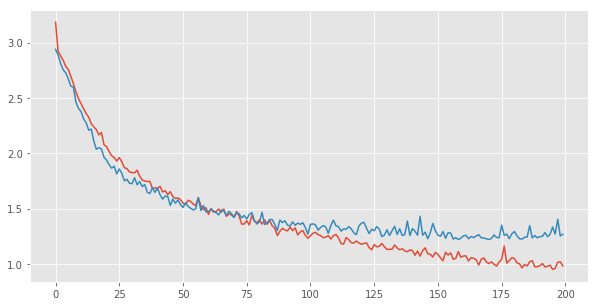

In [27]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

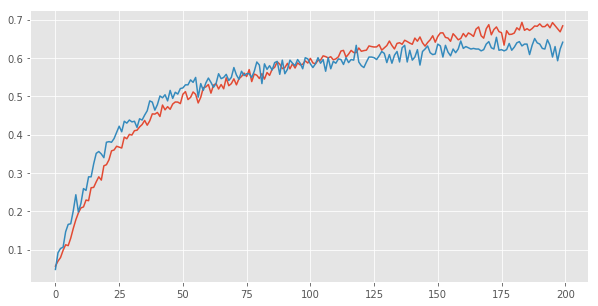

In [28]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.58743961352657
Confusion matrix, without normalization
[[35  0  0  1  1  2  1  0  0  0  0  0  1  1  0  0  3  6  2]
 [ 6 21  1  1  3  1  1  0  0  3  0  0  1  1  0  0  2  1  0]
 [ 0  0 43  0  1  0  0  8  0  0  0  1  0  0  0  1  0  0  1]
 [ 1  0  1 24  1  4  4  5  0  8  1  0  0  6  0  1  0  1  7]
 [ 1  2  0  0 30  0  2  0  1  3  0  0  0  0  3  2  0  3  1]
 [ 0  0  0  1  0 32  0  1  2  0  0  3  2  2  0  1  2  0  3]
 [ 3  0 12  1  0  1 23  3  0  2  0  1  2  0  0  1  1  1  5]
 [ 0  0  4  1  0  1  0 23  1  2  3  0  0  0  0  0  1  0 12]
 [ 5  1  0  3  3  8  2  5 39  0  0  3  2  1  0  0  0  3  3]
 [ 0  0  0  2  0  0  3  2  1 37  0  3  0  2  0  2  0  0  6]
 [ 0  0  0  0  0  0  0  3  0  0 63  1  0  0  0  0  0  0  6]
 [ 1  0  0  0  2  1  0  1  0  0  0 50  0  1  0  0  1  0  5]
 [ 2  0  6  1  0  4  4  1  2  0  0  3 22  1  1  0  4  0  8]
 [ 0  1  1  0  0  0  1  0  0  1  1  1  1 14  1  1  1  1  4]
 [ 0  0  1  1  0  0  0  0  0  0  0  0  0  0 56  0  0  0  0]
 [ 1  0  4  1  0  0  0  2  0  2  0  0  0  2

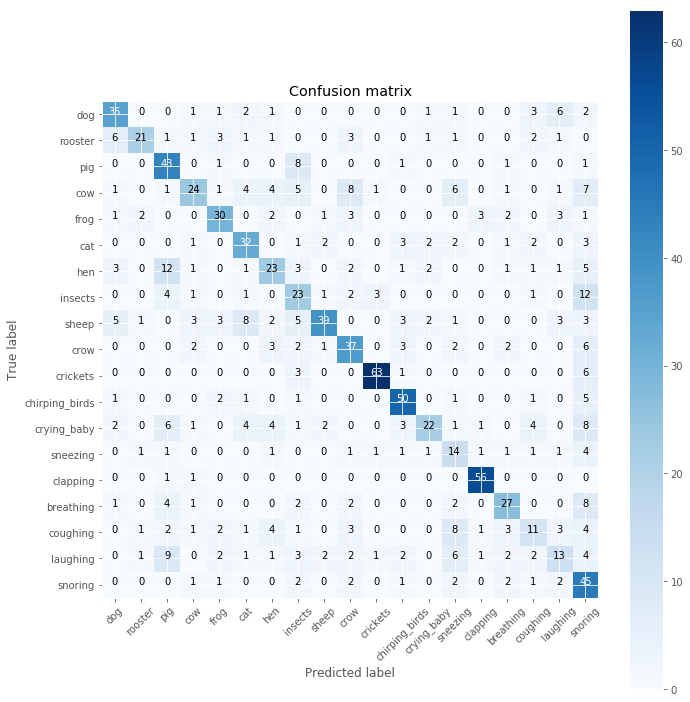

In [29]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [30]:
train_X, test_X, train_y, test_y = train_test_split(
                        i_data, i_targ, test_size=0.20, random_state=75)

In [31]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(16, (3,3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Convolution2D(32, (5,2), name='conv2', activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(31, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [32]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=epochs * 2, batch_size=batch, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_4 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 42, 16)       160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 2, 16)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 1, 32)          5152      
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

6016/6016 [==============================] - 6s 1ms/step - loss: 2.3207 - acc: 0.2414 - mean_absolute_error: 0.0551 - val_loss: 2.2415 - val_acc: 0.2637 - val_mean_absolute_error: 0.0543
Epoch 31/200
6016/6016 [==============================] - 6s 1ms/step - loss: 2.3511 - acc: 0.2415 - mean_absolute_error: 0.0552 - val_loss: 2.3229 - val_acc: 0.2458 - val_mean_absolute_error: 0.0551
Epoch 32/200
6016/6016 [==============================] - 6s 1ms/step - loss: 2.3002 - acc: 0.2525 - mean_absolute_error: 0.0549 - val_loss: 2.2225 - val_acc: 0.2674 - val_mean_absolute_error: 0.0541
Epoch 33/200
6016/6016 [==============================] - 6s 963us/step - loss: 2.2929 - acc: 0.2443 - mean_absolute_error: 0.0547 - val_loss: 2.2375 - val_acc: 0.2740 - val_mean_absolute_error: 0.0540
Epoch 34/200
6016/6016 [==============================] - 6s 940us/step - loss: 2.2953 - acc: 0.2440 - mean_absolute_error: 0.0548 - val_loss: 2.2898 - val_acc: 0.2495 - val_mean_absolute_error: 0.0539
Epoch 35/

Epoch 71/200
6016/6016 [==============================] - 6s 928us/step - loss: 2.2046 - acc: 0.2676 - mean_absolute_error: 0.0538 - val_loss: 2.1099 - val_acc: 0.2928 - val_mean_absolute_error: 0.0528
Epoch 72/200
6016/6016 [==============================] - 6s 943us/step - loss: 2.1908 - acc: 0.2771 - mean_absolute_error: 0.0536 - val_loss: 2.1026 - val_acc: 0.2966 - val_mean_absolute_error: 0.0525
Epoch 73/200
6016/6016 [==============================] - 5s 882us/step - loss: 2.2855 - acc: 0.2571 - mean_absolute_error: 0.0544 - val_loss: 2.1681 - val_acc: 0.2815 - val_mean_absolute_error: 0.0536
Epoch 74/200
6016/6016 [==============================] - 5s 826us/step - loss: 2.1888 - acc: 0.2778 - mean_absolute_error: 0.0536 - val_loss: 2.1396 - val_acc: 0.2947 - val_mean_absolute_error: 0.0531
Epoch 75/200
6016/6016 [==============================] - 6s 1ms/step - loss: 2.1608 - acc: 0.2852 - mean_absolute_error: 0.0532 - val_loss: 2.1195 - val_acc: 0.2994 - val_mean_absolute_error:

6016/6016 [==============================] - 6s 1ms/step - loss: 2.1264 - acc: 0.2987 - mean_absolute_error: 0.0527 - val_loss: 2.0297 - val_acc: 0.3192 - val_mean_absolute_error: 0.0514
Epoch 112/200
6016/6016 [==============================] - 6s 964us/step - loss: 2.0480 - acc: 0.3090 - mean_absolute_error: 0.0519 - val_loss: 2.0210 - val_acc: 0.3249 - val_mean_absolute_error: 0.0515
Epoch 113/200
6016/6016 [==============================] - 6s 937us/step - loss: 2.0693 - acc: 0.3103 - mean_absolute_error: 0.0521 - val_loss: 2.0288 - val_acc: 0.3267 - val_mean_absolute_error: 0.0508
Epoch 114/200
6016/6016 [==============================] - 6s 920us/step - loss: 2.0778 - acc: 0.2990 - mean_absolute_error: 0.0523 - val_loss: 2.0197 - val_acc: 0.3220 - val_mean_absolute_error: 0.0514
Epoch 115/200
6016/6016 [==============================] - 6s 953us/step - loss: 2.0908 - acc: 0.3000 - mean_absolute_error: 0.0522 - val_loss: 2.1444 - val_acc: 0.2891 - val_mean_absolute_error: 0.0522
E

6016/6016 [==============================] - 3s 505us/step - loss: 1.9524 - acc: 0.3418 - mean_absolute_error: 0.0502 - val_loss: 1.9488 - val_acc: 0.3484 - val_mean_absolute_error: 0.0499
Epoch 152/200
6016/6016 [==============================] - 3s 499us/step - loss: 1.9463 - acc: 0.3424 - mean_absolute_error: 0.0504 - val_loss: 1.8968 - val_acc: 0.3625 - val_mean_absolute_error: 0.0492
Epoch 153/200
6016/6016 [==============================] - 3s 462us/step - loss: 1.9198 - acc: 0.3414 - mean_absolute_error: 0.0501 - val_loss: 1.9082 - val_acc: 0.3672 - val_mean_absolute_error: 0.0495
Epoch 154/200
6016/6016 [==============================] - 3s 457us/step - loss: 1.9529 - acc: 0.3494 - mean_absolute_error: 0.0501 - val_loss: 1.9425 - val_acc: 0.3616 - val_mean_absolute_error: 0.0499
Epoch 155/200
6016/6016 [==============================] - 3s 466us/step - loss: 1.9541 - acc: 0.3353 - mean_absolute_error: 0.0504 - val_loss: 1.9619 - val_acc: 0.3371 - val_mean_absolute_error: 0.0504

6016/6016 [==============================] - 3s 445us/step - loss: 1.8900 - acc: 0.3625 - mean_absolute_error: 0.0492 - val_loss: 1.8765 - val_acc: 0.3682 - val_mean_absolute_error: 0.0484
Epoch 192/200
6016/6016 [==============================] - 3s 440us/step - loss: 1.8624 - acc: 0.3702 - mean_absolute_error: 0.0488 - val_loss: 1.8400 - val_acc: 0.3635 - val_mean_absolute_error: 0.0483
Epoch 193/200
6016/6016 [==============================] - 3s 442us/step - loss: 1.8160 - acc: 0.3831 - mean_absolute_error: 0.0482 - val_loss: 1.8683 - val_acc: 0.3644 - val_mean_absolute_error: 0.0482
Epoch 194/200
6016/6016 [==============================] - 3s 443us/step - loss: 1.8806 - acc: 0.3647 - mean_absolute_error: 0.0489 - val_loss: 1.9519 - val_acc: 0.3644 - val_mean_absolute_error: 0.0491
Epoch 195/200
6016/6016 [==============================] - 3s 444us/step - loss: 1.8504 - acc: 0.3715 - mean_absolute_error: 0.0487 - val_loss: 1.8707 - val_acc: 0.3540 - val_mean_absolute_error: 0.0486

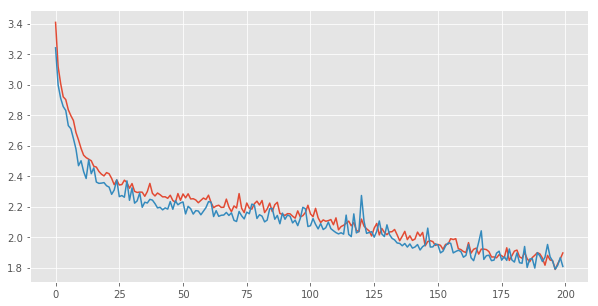

In [33]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

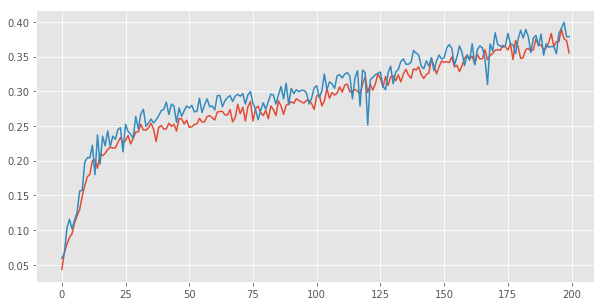

In [34]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.37175141242937854
Confusion matrix, without normalization
[[58  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 2 52  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  4  2  0  0  0  0]
 [ 0  0 43  0  0  2  1  0  2  3  0  0  0  5  0  1  0  0  0  0  0  1  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  1  0  0  3  2  2  0  0  0  0  6 12  2  0  0  0
   0  0  0  0  0  5  0]
 [ 9 22  0  0 15  0  3  0  0  4  0  0  0  0  1  0  4  0  0  0  0  4  1  0
   0  6  0  0  0  0  0]
 [ 0  0  5  0  0  3  0  0 10  1  0  4  0  9  0  3  0  0  2  2  2  1  0  0
   0  0  0  0  1  0  0]
 [ 8  6  0  0  2  0  8  0  0  8  0  0  0  0  0  0  0  4  1  1  0  3  5  1
   0  1  0  0  1  1  2]
 [ 0  0  0  0  5  0  0  9  5  0  0  3  0  0  0  1  0  0  0 11  0  1  0  0
   0  3  5  0 10  8  0]
 [ 0  0  7  0  0  0  0  0 20  1  0  1  1  8  0  1  0  0  0  9  0  0  0  0
   0  1  0  0  0  1  1]
 [ 0  3  4  0  2  1  7  2  5 19  0  0  0  0  0  0  0  1  1

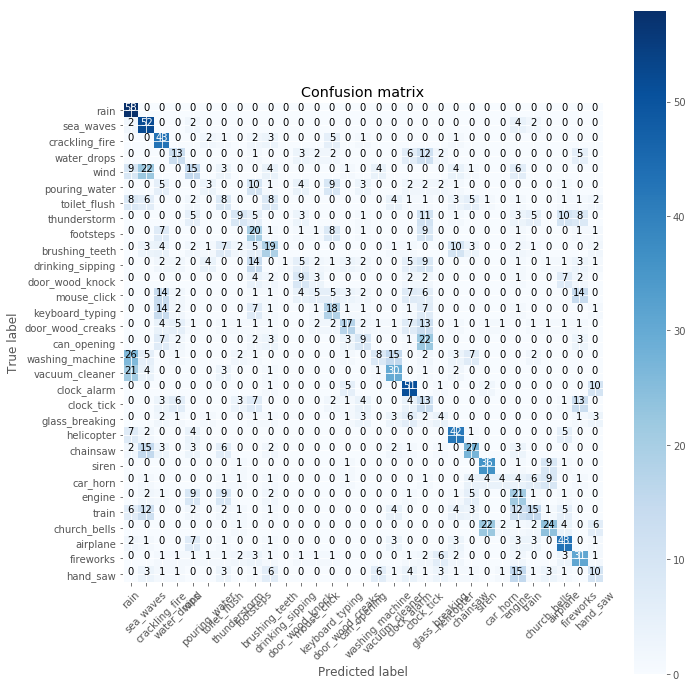

In [35]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [36]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 6.770447731018066
	Processing Time: 6.404595851898193
	Processing Time: 6.540366172790527
	Processing Time: 6.774433851242065


In [37]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(56774, 1, 11025)


In [38]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(56774,)


In [39]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(56774,)


0.7158030084193469
Confusion matrix, without normalization
[[11367  9737]
 [ 6398 29272]]


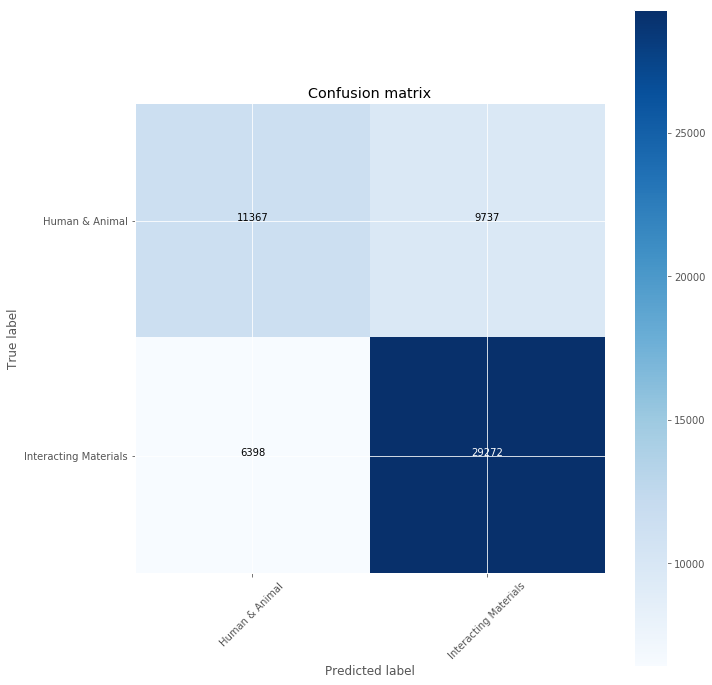

In [40]:
pred = clas.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [41]:
test_a_data = X[y == 0]
test_a_targ = yy[y == 0]
test_i_data = X[y == 1]
test_i_targ = yy[y == 1]

0.3115996967399545
Confusion matrix, without normalization
[[459   9  40  43  13  34 152   3   6  14   0   5  40  83  33  24  47  41
   61]
 [ 67 277  15  37  23  47  40   1   4  59   9   7  45 124   1   7  34  27
   61]
 [  7   8 352  38  10   5  40  69  14  52  17  15  19  22 146  19  63  20
  160]
 [107  12  88 306   6  24 219  51  33  19  18  10  42  21   5  36  21  14
   81]
 [ 88  87  66  27 308   3  11   8  87  58   6  93  16  30 202  72  30  28
   24]
 [103 115   4  80  14 138  52   8  17  29   9  20  77  66   9   9  45  36
  198]
 [134  15  99  29   9  25 315  52  13  17  29  10 140   8   9  70  62  39
   78]
 [ 28   1 145  61  39  29  32 491  26  29  22  48  13   6  61  12  21   1
  146]
 [ 46  15 100  78  56  36  47 121 309 112   8  62  25  11  68  46  19  13
   62]
 [ 54   7 101  82 102   5  37  81  53 410  15  19   0  22  70  22   8   5
   44]
 [ 21   0  34   6   1   8   1 182   1  59 190 469   1  36   0   2   2   2
  233]
 [ 39   5 111  16  16  17  22  88  35  11 106 583 

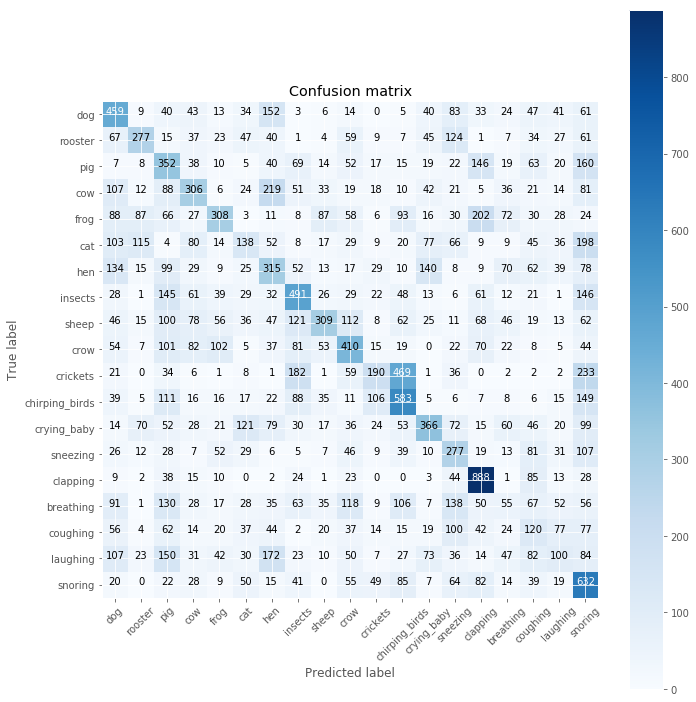

In [42]:
pred = anim.predict(test_a_data)
print(metrics.accuracy_score(test_a_targ, pred))
cm = metrics.confusion_matrix(test_a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

0.17560975609756097
Confusion matrix, without normalization
[[605 167   5   0   5   0  22   0   0   7   0   1   0   0   0   0   5 134
    0   1   0 128  64   0   0   8  49   2  42   0   3]
 [109 492   2   2   7   0   8   1   1   9   0   0   0   0   1   0   2  40
    4   1   0   4 493  12  12  18  10   5   9   0   0]
 [ 34  16 462   3  24  23 152   0  52 109   1   0   1  68   5   0   4  17
    2  17   2 111  53   0   0  54   1   0   0   0   3]
 [  1   0  98  78  13  15  13  26 106  14   3  44  20  61  17  96   0   0
   47 158  29  13   0   3   0  38   3   0  27  94  15]
 [ 13 245   0   0  31   0   8   0   1  36   0   0   0   0   2   0  22   7
    0   0   0   6 101  42  24 158 405  28  46   0  73]
 [  0   0 301  28   8  71  27  14 147  93   3  35   5 112  11  54   0   0
   68  62  25  12   8   6   0  41   2   5   2  19  22]
 [323 106  33   1  16   2 134   3  16 113   1   1   3   2   2   1   9 108
    6  29   0 106  72   0   1  63  27   6   8   8  38]
 [ 44  85   1   4  67   0   7  65  16

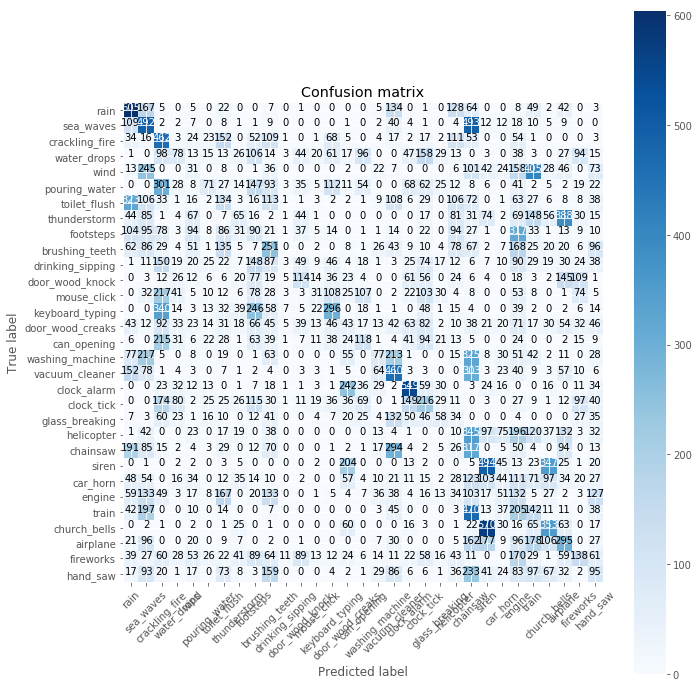

In [43]:
pred = inter.predict(test_i_data)
print(metrics.accuracy_score(test_i_targ, pred))
cm = metrics.confusion_matrix(test_i_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

In [44]:
clas.predict_proba(X)

array([[0.84368336, 0.15631667],
       [0.3013215 , 0.6986785 ],
       [0.47641426, 0.52358574],
       ...,
       [0.35563964, 0.64436036],
       [0.36538225, 0.63461775],
       [0.36520708, 0.6347929 ]], dtype=float32)

# Testing Accuracy of Single File

In [45]:
data_iloc = 1

In [46]:
def load_file_audio_blockwise(file, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    h_cat = []
    cat = []

    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + file['filename'], 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True, 
                         fill_value=0.0)
    SR = sf.info(audio_dir + file['filename']).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        h_cat.append(file.h_category)
        cat.append(file.target)
    if debug:
        print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

In [47]:
x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)

	Processing Time: 0.01649951934814453


In [48]:
pred_prob = clas.predict_proba(x_file, verbose=1)
pred = clas.predict(x_file, verbose=1)

39/39 [==============================] - 0s 209us/step


In [49]:
np.average(pred_prob, axis=0)

array([0.7802991 , 0.21970111], dtype=float32)

In [50]:
pred_prob = anim.predict_proba(x_file, verbose=1)
pred = anim.predict(x_file, verbose=1)

39/39 [==============================] - 0s 242us/step


In [51]:
np.average(pred_prob, axis=0)

array([3.7136659e-05, 1.9660636e-03, 1.1048010e-01, 2.9068559e-03,
       6.2074522e-03, 9.9436706e-04, 9.3878834e-03, 7.5728126e-02,
       3.4172114e-03, 1.9214224e-02, 1.1141931e-03, 5.1524341e-01,
       5.3383313e-02, 2.4665195e-02, 2.1248893e-04, 3.4918236e-03,
       6.1229076e-02, 8.6110793e-02, 2.4210330e-02], dtype=float32)

In [52]:
from collections import Counter
b = Counter(pred)
print(b.most_common(1)[0][0])

14


In [53]:
print(dataset.iloc[data_iloc])

filename      1-100038-A-14.wav
fold                          1
target                       14
category         chirping_birds
esc10                     False
src_file                 100038
take                          A
h_category                    0
Name: 1, dtype: object


In [54]:
predictions = []
full_targets = []
start_time = time.time()

for data_iloc in range(0,2000):
    x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)
    pred = clas.predict(x_file, verbose=0)[:,0]
    b = Counter(pred)
    if b.most_common(1)[0][0] == 0:
        pred = anim.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
    else:
        pred = inter.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(yy_file[0])

print("\tProcessing Time: " + str(time.time() - start_time))

	Processing Time: 0.011237621307373047
	Processing Time: 0.012377262115478516
	Processing Time: 0.011414766311645508
	Processing Time: 0.011430025100708008
	Processing Time: 0.012659072875976562
	Processing Time: 0.01252889633178711
	Processing Time: 0.009687662124633789
	Processing Time: 0.011516332626342773
	Processing Time: 0.01142430305480957
	Processing Time: 0.008240461349487305
	Processing Time: 0.009586811065673828
	Processing Time: 0.011554241180419922
	Processing Time: 0.01156306266784668
	Processing Time: 0.011383771896362305
	Processing Time: 0.007758617401123047
	Processing Time: 0.011492490768432617
	Processing Time: 0.011500358581542969
	Processing Time: 0.011600017547607422
	Processing Time: 0.011487722396850586
	Processing Time: 0.01865673065185547
	Processing Time: 0.013493776321411133
	Processing Time: 0.012389183044433594
	Processing Time: 0.012429237365722656
	Processing Time: 0.012443065643310547
	Processing Time: 0.01833200454711914
	Processing Time: 0.0126805305

	Processing Time: 0.012841939926147461
	Processing Time: 0.012706756591796875
	Processing Time: 0.011273622512817383
	Processing Time: 0.01133584976196289
	Processing Time: 0.011511564254760742
	Processing Time: 0.011568546295166016
	Processing Time: 0.011539697647094727
	Processing Time: 0.011556625366210938
	Processing Time: 0.009521484375
	Processing Time: 0.009300708770751953
	Processing Time: 0.01281285285949707
	Processing Time: 0.012581586837768555
	Processing Time: 0.011508464813232422
	Processing Time: 0.01262664794921875
	Processing Time: 0.012251853942871094
	Processing Time: 0.01343989372253418
	Processing Time: 0.011216163635253906
	Processing Time: 0.011367321014404297
	Processing Time: 0.010471105575561523
	Processing Time: 0.011574506759643555
	Processing Time: 0.01137995719909668
	Processing Time: 0.011579751968383789
	Processing Time: 0.009813547134399414
	Processing Time: 0.009919166564941406
	Processing Time: 0.011551141738891602
	Processing Time: 0.0115551948547363

	Processing Time: 0.013387203216552734
	Processing Time: 0.012265205383300781
	Processing Time: 0.012237071990966797
	Processing Time: 0.012222528457641602
	Processing Time: 0.012191057205200195
	Processing Time: 0.01224970817565918
	Processing Time: 0.012201070785522461
	Processing Time: 0.01221609115600586
	Processing Time: 0.012182474136352539
	Processing Time: 0.012215375900268555
	Processing Time: 0.012202024459838867
	Processing Time: 0.012209653854370117
	Processing Time: 0.012180805206298828
	Processing Time: 0.011386871337890625
	Processing Time: 0.012207269668579102
	Processing Time: 0.012202978134155273
	Processing Time: 0.011263370513916016
	Processing Time: 0.011089086532592773
	Processing Time: 0.010738372802734375
	Processing Time: 0.012336969375610352
	Processing Time: 0.01123189926147461
	Processing Time: 0.011079788208007812
	Processing Time: 0.011161327362060547
	Processing Time: 0.011133193969726562
	Processing Time: 0.011178970336914062
	Processing Time: 0.01112699

	Processing Time: 0.012282371520996094
	Processing Time: 0.01220250129699707
	Processing Time: 0.011256694793701172
	Processing Time: 0.011306047439575195
	Processing Time: 0.011281013488769531
	Processing Time: 0.008720874786376953
	Processing Time: 0.011321306228637695
	Processing Time: 0.012279272079467773
	Processing Time: 0.01216268539428711
	Processing Time: 0.012571096420288086
	Processing Time: 0.011346817016601562
	Processing Time: 0.011343717575073242
	Processing Time: 0.011361837387084961
	Processing Time: 0.011393547058105469
	Processing Time: 0.009785890579223633
	Processing Time: 0.010121345520019531
	Processing Time: 0.009721994400024414
	Processing Time: 0.012125015258789062
	Processing Time: 0.011318445205688477
	Processing Time: 0.010087728500366211
	Processing Time: 0.011347770690917969
	Processing Time: 0.011293649673461914
	Processing Time: 0.011398077011108398
	Processing Time: 0.011260032653808594
	Processing Time: 0.01126551628112793
	Processing Time: 0.01125025

	Processing Time: 0.012818336486816406
	Processing Time: 0.011361837387084961
	Processing Time: 0.011347055435180664
	Processing Time: 0.011349916458129883
	Processing Time: 0.01126718521118164
	Processing Time: 0.011314868927001953
	Processing Time: 0.01134181022644043
	Processing Time: 0.012411832809448242
	Processing Time: 0.011284351348876953
	Processing Time: 0.01132059097290039
	Processing Time: 0.011291742324829102
	Processing Time: 0.011268377304077148
	Processing Time: 0.011301279067993164
	Processing Time: 0.011316061019897461
	Processing Time: 0.011388540267944336
	Processing Time: 0.011327266693115234
	Processing Time: 0.011340141296386719
	Processing Time: 0.011279582977294922
	Processing Time: 0.008758068084716797
	Processing Time: 0.01129460334777832
	Processing Time: 0.011366844177246094
	Processing Time: 0.012372493743896484
	Processing Time: 0.011418819427490234
	Processing Time: 0.011307954788208008
	Processing Time: 0.011418581008911133
	Processing Time: 0.009438991

	Processing Time: 0.011263370513916016
	Processing Time: 0.011244773864746094
	Processing Time: 0.011832714080810547
	Processing Time: 0.011455297470092773
	Processing Time: 0.012507200241088867
	Processing Time: 0.012204885482788086
	Processing Time: 0.010099649429321289
	Processing Time: 0.010461568832397461
	Processing Time: 0.008665800094604492
	Processing Time: 0.008272409439086914
	Processing Time: 0.011145353317260742
	Processing Time: 0.0111083984375
	Processing Time: 0.011132955551147461
	Processing Time: 0.01238107681274414
	Processing Time: 0.011177778244018555
	Processing Time: 0.01113581657409668
	Processing Time: 0.01110076904296875
	Processing Time: 0.011279106140136719
	Processing Time: 0.011186838150024414
	Processing Time: 0.010162353515625
	Processing Time: 0.01217508316040039
	Processing Time: 0.011173248291015625
	Processing Time: 0.010634660720825195
	Processing Time: 0.00999307632446289
	Processing Time: 0.009648799896240234
	Processing Time: 0.011147499084472656

	Processing Time: 0.011262178421020508
	Processing Time: 0.011246204376220703
	Processing Time: 0.011260032653808594
	Processing Time: 0.011230945587158203
	Processing Time: 0.011202096939086914
	Processing Time: 0.011278629302978516
	Processing Time: 0.00906682014465332
	Processing Time: 0.01224970817565918
	Processing Time: 0.011258125305175781
	Processing Time: 0.011349916458129883
	Processing Time: 0.011180400848388672
	Processing Time: 0.011282920837402344
	Processing Time: 0.011287450790405273
	Processing Time: 0.01126718521118164
	Processing Time: 0.011384963989257812
	Processing Time: 0.011432409286499023
	Processing Time: 0.011065006256103516
	Processing Time: 0.01110529899597168
	Processing Time: 0.0110626220703125
	Processing Time: 0.011103630065917969
	Processing Time: 0.007913351058959961
	Processing Time: 0.01103973388671875
	Processing Time: 0.008700847625732422
	Processing Time: 0.01108241081237793
	Processing Time: 0.011127948760986328
	Processing Time: 0.0111889839172

	Processing Time: 0.011236190795898438
	Processing Time: 0.01131296157836914
	Processing Time: 0.011312484741210938
	Processing Time: 0.011291265487670898
	Processing Time: 0.011289596557617188
	Processing Time: 0.011290550231933594
	Processing Time: 0.008945941925048828
	Processing Time: 0.012317419052124023
	Processing Time: 0.011335372924804688
	Processing Time: 0.011264562606811523
	Processing Time: 0.011344671249389648
	Processing Time: 0.012018918991088867
	Processing Time: 0.012357711791992188
	Processing Time: 0.011323213577270508
	Processing Time: 0.011385440826416016
	Processing Time: 0.011312484741210938
	Processing Time: 0.011274099349975586
	Processing Time: 0.011229991912841797
	Processing Time: 0.008139848709106445
	Processing Time: 0.012431621551513672
	Processing Time: 0.011310100555419922
	Processing Time: 0.011269569396972656
	Processing Time: 0.011276483535766602
	Processing Time: 0.008205890655517578
	Processing Time: 0.007876396179199219
	Processing Time: 0.008771

	Processing Time: 0.011142969131469727
	Processing Time: 0.011124372482299805
	Processing Time: 0.011262893676757812
	Processing Time: 0.011263370513916016
	Processing Time: 0.011255025863647461
	Processing Time: 0.011243343353271484
	Processing Time: 0.011283159255981445
	Processing Time: 0.011210441589355469
	Processing Time: 0.011258602142333984
	Processing Time: 0.011319398880004883
	Processing Time: 0.011245250701904297
	Processing Time: 0.011272907257080078
	Processing Time: 0.011202573776245117
	Processing Time: 0.01257467269897461
	Processing Time: 0.011277437210083008
	Processing Time: 0.011242866516113281
	Processing Time: 0.012499809265136719
	Processing Time: 0.011088848114013672
	Processing Time: 0.011066913604736328
	Processing Time: 0.011309623718261719
	Processing Time: 0.01128244400024414
	Processing Time: 0.011290311813354492
	Processing Time: 0.011275529861450195
	Processing Time: 0.011262655258178711
	Processing Time: 0.011305093765258789
	Processing Time: 0.0111529

	Processing Time: 0.012185096740722656
	Processing Time: 0.011755704879760742
	Processing Time: 0.011130809783935547
	Processing Time: 0.011085271835327148
	Processing Time: 0.011095285415649414
	Processing Time: 0.01254129409790039
	Processing Time: 0.011283159255981445
	Processing Time: 0.011307239532470703
	Processing Time: 0.011328458786010742
	Processing Time: 0.011320114135742188
	Processing Time: 0.011305809020996094
	Processing Time: 0.011320829391479492
	Processing Time: 0.011160612106323242
	Processing Time: 0.011183977127075195
	Processing Time: 0.011229276657104492
	Processing Time: 0.01123046875
	Processing Time: 0.010901212692260742
	Processing Time: 0.01104283332824707
	Processing Time: 0.01125025749206543
	Processing Time: 0.012318849563598633
	Processing Time: 0.007677316665649414
	Processing Time: 0.011212825775146484
	Processing Time: 0.011217355728149414
	Processing Time: 0.011292219161987305
	Processing Time: 0.011205434799194336
	Processing Time: 0.007910728454589

In [55]:
targs = np.vstack(full_targets)

0.2
Confusion matrix, without normalization
[[19  0  0 ...  1  3  0]
 [ 0 19  0 ...  1  2  0]
 [ 0  0 20 ...  0  0  2]
 ...
 [ 0  0  0 ...  3  0  2]
 [ 0  0  0 ...  5  4  1]
 [ 0  0  8 ...  0  0  3]]


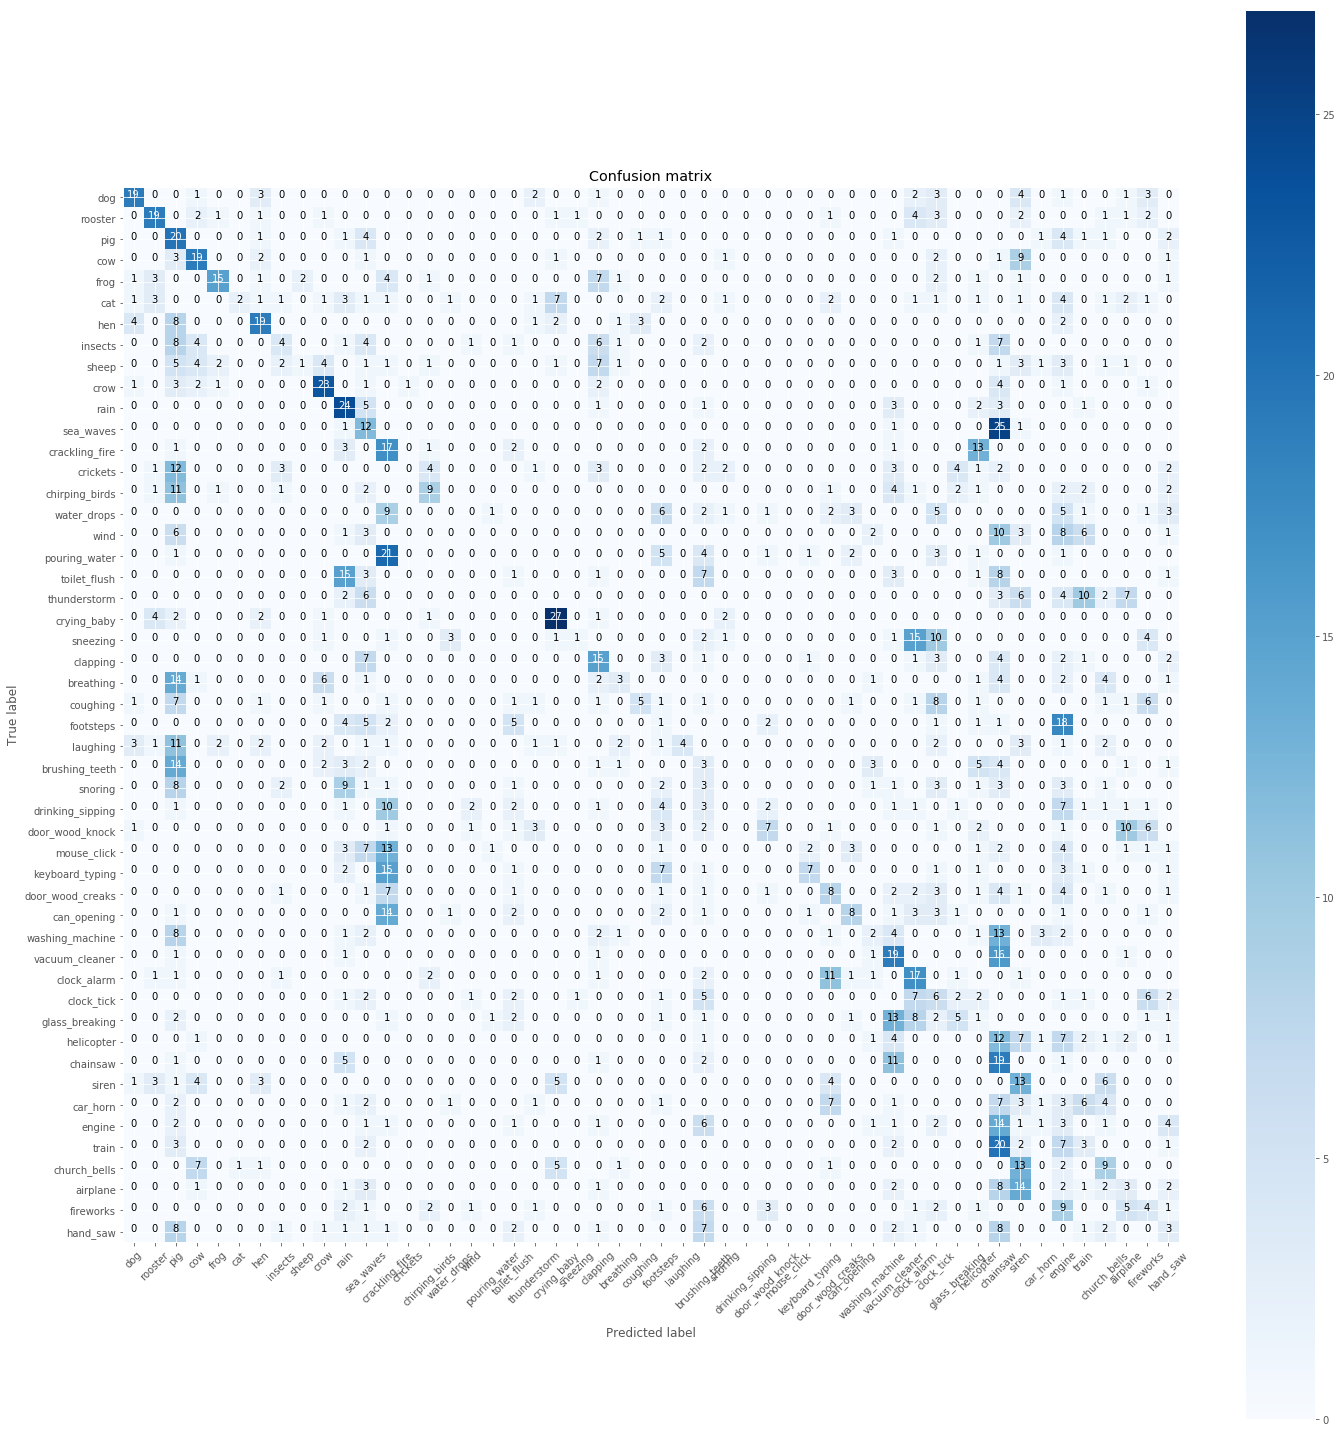

In [56]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()